In [114]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd
import seaborn as sns

import csp_problems
import parser
import constraint
import os

In [81]:
path = 'logs/'
# filenames = os.listdir(path)

In [105]:
def decompose_filename(filename):
    info = {}
    decomp = filename.split('.')[0].split('_')
    info['solver'] = decomp.pop(0)
    info['problem_type'] = decomp.pop(0)
    info['problem_instance'] = '_'.join(decomp)
    info['filename'] = filename
    return info

def parse_info_filename(path, filename):
    with open(os.path.join(path, filename)) as file:
        input_data = file.read()
    lines = input_data.split('\n')[:-1]
    lines_type = [line.split('-')[0] for line in lines]
    calls = collections.Counter(lines_type)
    return calls

def get_dataframe(path):
    filenames = os.listdir(path)
    infos = []
    for filename in filenames:
        info = decompose_filename(filename)
        calls = parse_info_filename(path, filename)
        infos.append({**info, **calls})
    return pd.DataFrame(infos)

In [152]:
df = get_dataframe(path)

In [153]:
df.head()

,solver,problem_type,problem_instance,filename,DEBUG:root:nmcs call,DEBUG:root:assign,DEBUG:root:playout,DEBUG:root:end playout negative,DEBUG:root:end playout positive
0,nmcs-1,nqueens-sym-simple,nqueens_96,nmcs-1_nqueens-sym-simple_nqueens_96.log,5.0,4.0,4,3.0,1.0
1,nmcs-1,coloring,gc_100_3_10,nmcs-1_coloring_gc_100_3_10.log,57211.0,57210.0,57210,57209.0,NaN
2,nrpa-1-100-heur-old,sudoku,5_7,nrpa-1-100-heur-old_sudoku_5_7.log,NaN,NaN,1261,1261.0,NaN
3,nrpa-1-100-heur,coloring,gc_20_7_8,nrpa-1-100-heur_coloring_gc_20_7_8.log,NaN,NaN,7,6.0,1.0
4,nrpa-1-100-heur-old,sudoku,3_0,nrpa-1-100-heur-old_sudoku_3_0.log,NaN,NaN,2,1.0,1.0


In [155]:
df['problem_type'].value_counts()

coloring              108
sudoku                 90
nqueens-sym            24
nqueens                24
nqueens-sym-simple     16
Name: problem_type, dtype: int64

In [154]:
df['solver'].value_counts()

nrpa-1-100-heur        90
nmcs-1                 90
nrpa-1-100-heur-old    74
nmcs-2                  8
Name: solver, dtype: int64

In [107]:
metrics = [col for col in df.columns if col.startswith('DEBUG')]

In [163]:
df.loc[df['DEBUG:root:end playout positive']>1]

,solver,problem_type,problem_instance,filename,DEBUG:root:nmcs call,DEBUG:root:assign,DEBUG:root:playout,DEBUG:root:end playout negative,DEBUG:root:end playout positive
36,nmcs-1,sudoku,4_7,nmcs-1_sudoku_4_7.log,11431.0,11430.0,11430,11363.0,67.0
37,nrpa-1-100-heur-old,nqueens-sym,nqueens_16,nrpa-1-100-heur-old_nqueens-sym_nqueens_16.log,NaN,NaN,2,NaN,2.0
38,nrpa-1-100-heur-old,nqueens-sym,nqueens_8,nrpa-1-100-heur-old_nqueens-sym_nqueens_8.log,NaN,NaN,5,3.0,2.0
55,nrpa-1-100-heur-old,nqueens-sym,nqueens_96,nrpa-1-100-heur-old_nqueens-sym_nqueens_96.log,NaN,NaN,48,46.0,2.0
81,nrpa-1-100-heur-old,nqueens-sym,nqueens_32,nrpa-1-100-heur-old_nqueens-sym_nqueens_32.log,NaN,NaN,79,77.0,2.0
140,nmcs-1,sudoku,4_2,nmcs-1_sudoku_4_2.log,4342.0,4341.0,4341,4308.0,33.0
146,nmcs-1,sudoku,4_3,nmcs-1_sudoku_4_3.log,13874.0,13873.0,13873,13866.0,7.0
205,nrpa-1-100-heur-old,nqueens-sym,nqueens_192,nrpa-1-100-heur-old_nqueens-sym_nqueens_192.log,NaN,NaN,19,17.0,2.0
206,nrpa-1-100-heur-old,nqueens-sym,nqueens_128,nrpa-1-100-heur-old_nqueens-sym_nqueens_128.log,NaN,NaN,100,98.0,2.0
230,nrpa-1-100-heur-old,nqueens-sym,nqueens_64,nrpa-1-100-heur-old_nqueens-sym_nqueens_64.log,NaN,NaN,54,52.0,2.0


In [162]:
df.loc[df['solver'].isin(['nrpa-1-100-heur', 'nmcs-1'])].groupby(['problem_type', 'solver'])[metrics].sum()

DEBUG:root:nmcs call  DEBUG:root:assign  \
problem_type       solver                                                     
coloring           nmcs-1                       897661.0           897625.0   
                   nrpa-1-100-heur                   0.0                0.0   
nqueens            nmcs-1                           68.0               60.0   
                   nrpa-1-100-heur                   0.0                0.0   
nqueens-sym        nmcs-1                          543.0              535.0   
                   nrpa-1-100-heur                   0.0                0.0   
nqueens-sym-simple nmcs-1                           60.0               52.0   
                   nrpa-1-100-heur                   0.0                0.0   
sudoku             nmcs-1                       204053.0           204023.0   
                   nrpa-1-100-heur                   0.0                0.0   

                                    DEBUG:root:playout  \
problem_type       solver                                
coloring           nmcs-1                       897625   
                   nrpa-1-100-heur               25472   
nqueens            nmcs-1                           60   
                   nrpa-1-100-heur                  38   
nqueens-sym        nmcs-1                          535   
                   nrpa-1-100-heur                1341   
nqueens-sym-simple nmcs-1                           52   
                   nrpa-1-100-heur                  73   
sudoku             nmcs-1                       204023   
                   nrpa-1-100-heur               12675   

                                    DEBUG:root:end playout negative  \
problem_type       solver                                             
coloring           nmcs-1                                  897595.0   
                   nrpa-1-100-heur                          25453.0   
nqueens            nmcs-1                                      52.0   
                   nrpa-1-100-heur                             30.0   
nqueens-sym        nmcs-1                                     527.0   
                   nrpa-1-100-heur                           1334.0   
nqueens-sym-simple nmcs-1                                      44.0   
                   nrpa-1-100-heur                             65.0   
sudoku             nmcs-1                                  203893.0   
                   nrpa-1-100-heur                          12655.0   

                                    DEBUG:root:end playout positive  
problem_type       solver                                            
coloring           nmcs-1                                      11.0  
                   nrpa-1-100-heur                             17.0  
nqueens            nmcs-1                                       8.0  
                   nrpa-1-100-heur                              8.0  
nqueens-sym        nmcs-1                                       6.0  
                   nrpa-1-100-heur                              7.0  
nqueens-sym-simple nmcs-1                                       8.0  
                   nrpa-1-100-heur                              8.0  
sudoku             nmcs-1                                     125.0  
                   nrpa-1-100-heur                             19.0

In [157]:
grouped = df.loc[df['solver'].isin(['nrpa-1-100-heur', 'nmcs-1'])].groupby(['solver'])[metrics].mean()#.plot.bar()
grouped

,DEBUG:root:nmcs call,DEBUG:root:assign,DEBUG:root:playout,DEBUG:root:end playout negative,DEBUG:root:end playout positive
solver,,,,,
nmcs-1,12248.722222,12247.722222,12247.722222,14501.460526,3.098039
nrpa-1-100-heur,NaN,NaN,439.988889,500.468354,1.000000


In [151]:
df.loc[df['problem_instance']=='nqueens_96']

,solver,problem_type,problem_instance,filename,DEBUG:root:nmcs call,DEBUG:root:assign,DEBUG:root:playout,DEBUG:root:end playout negative,DEBUG:root:end playout positive
0,nmcs-1,nqueens-sym-simple,nqueens_96,nmcs-1_nqueens-sym-simple_nqueens_96.log,5.0,4.0,4,3.0,1.0
55,nrpa-1-100-heur-old,nqueens-sym,nqueens_96,nrpa-1-100-heur-old_nqueens-sym_nqueens_96.log,NaN,NaN,48,46.0,2.0
74,nmcs-1,nqueens-sym,nqueens_96,nmcs-1_nqueens-sym_nqueens_96.log,77.0,76.0,76,75.0,1.0
100,nrpa-1-100-heur,nqueens-sym-simple,nqueens_96,nrpa-1-100-heur_nqueens-sym-simple_nqueens_96.log,NaN,NaN,22,21.0,1.0
101,nmcs-2,nqueens,nqueens_96,nmcs-2_nqueens_nqueens_96.log,7.0,6.0,5,4.0,1.0
134,nrpa-1-100-heur,nqueens-sym,nqueens_96,nrpa-1-100-heur_nqueens-sym_nqueens_96.log,NaN,NaN,2,1.0,1.0
184,nrpa-1-100-heur,nqueens,nqueens_96,nrpa-1-100-heur_nqueens_nqueens_96.log,NaN,NaN,4,3.0,1.0


In [142]:
grouped.stack().reset_index().rename(columns = {'level_1':'log_type', 0:'mean'}).set_index('log_type')

,solver,mean
log_type,,
DEBUG:root:nmcs call,nmcs,2.000000
DEBUG:root:assign,nmcs,1.000000
DEBUG:root:playout,nmcs,1.000000
DEBUG:root:end playout positive,nmcs,1.000000
DEBUG:root:nmcs call,nmcs-1,12386.325843
DEBUG:root:assign,nmcs-1,12385.325843
DEBUG:root:playout,nmcs-1,12385.325843
DEBUG:root:end playout negative,nmcs-1,14501.460526
DEBUG:root:end playout positive,nmcs-1,3.140000


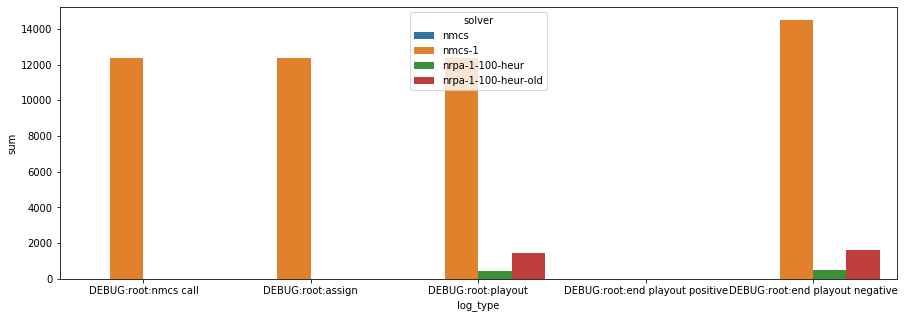

In [145]:
plt.figure(figsize=(15,5))
sns.barplot(x='log_type', y='sum', data=grouped.stack().reset_index().rename(columns = {'level_1':'log_type', 0:'sum'}), hue='solver')